In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate
from tf_rl.models import MLP

In [4]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmpY8TlFK


In [5]:
from tf_rl.simulation import DiscreteHill

In [6]:
# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.python.framework.ops.reset_default_graph()
session = tf.InteractiveSession()

# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
brain = MLP([4,], [10, 4], 
            [tf.tanh, tf.identity])

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = DiscreteDeepQ(4, 4, brain, optimizer, session,
                                   discount_rate=0.9, exploration_period=100, max_experience=10000, 
                                   store_every_nth=1, train_every_nth=4, target_network_update_rate=0.1,
                                   summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
# graph was not available when journalist was created  
journalist.add_graph(session.graph_def)

In [7]:
performances = []

try:
    for game_idx in range(10000):
        game = DiscreteHill()
        game_iterations = 0

        observation = game.observe()

        while game_iterations < 50 and not game.is_over():
            action = current_controller.action(observation)
            reward = game.collect_reward(action)
            game.perform_action(action)
            new_observation = game.observe()
            current_controller.store(observation, action, reward, new_observation)
            current_controller.training_step()
            observation = new_observation
            game_iterations += 1
        performance = float(game_iterations - (game.shortest_path)) / game.shortest_path
        performances.append(performance)
        if game_idx % 100 == 0:
            print "\rGame %d: iterations before success %d." % (game_idx, game_iterations),
            print "Pos: %s, Target: %s" % (game.position, game.target),
except KeyboardInterrupt:
    print "Interrupted"

Game 9900: iterations before success 50. Pos: (0, 32), Target: (5, -5)


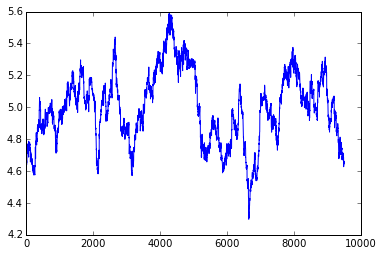

In [8]:
N = 500
smooth_performances = [float(sum(performances[i:i+N])) / N for i in range(0, len(performances) - N)]

plt.plot(range(len(smooth_performances)), smooth_performances)

In [9]:
np.average(performances[-1000:])

4.8415292036910458

<matplotlib.colorbar.Colorbar instance at 0x7efd13f040e0>

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


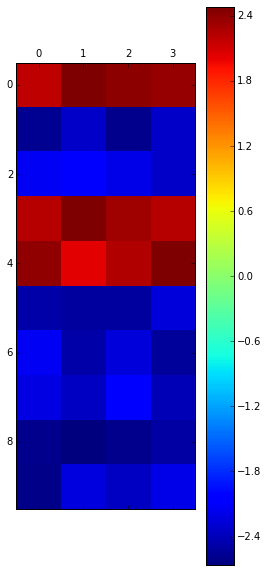

In [10]:
x = brain.layers[0].Ws[0].eval()
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(x)
plt.colorbar()

In [11]:
brain.input_layer.b.eval()

array([-2.92984366,  2.98327565,  2.91551542, -2.92384887, -2.96699572,
        2.94030881,  2.94943261,  2.89691925,  2.92639375,  2.94380689], dtype=float32)

In [12]:
game.collect_reward(0)

-3

In [13]:
x = tf.Variable(tf.zeros((5,5)))

In [14]:
tf.clip_by_norm(x, 5)

<tf.Tensor 'clip_by_norm:0' shape=(5, 5) dtype=float32>